SSE Score: 345.210530 | Training: ========================================                   
SSE Score: 138.450379 | Training: ========================================                   
SSE Score: 43.119829 | Training: ========================================                   

Initial Ensemble R^2: 0.7183969201936138
Final Ensemble R^2: 0.930151140571067
K1, K2 Constants: (1.189999999999996, 1)


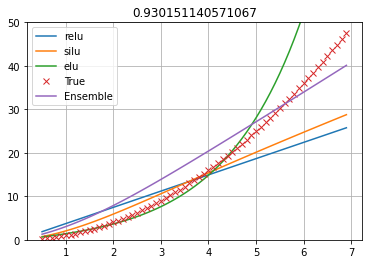

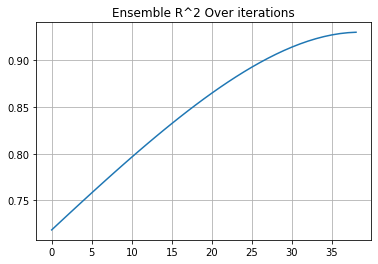

In [158]:
import numpy as np
import matplotlib.pyplot as plt
import main as mc

# Dataset
xshort = np.arange(1, 5, 0.1)
yshort = xshort**2

xfull = np.arange(0.5, 7, 0.1)
yfull = xfull**2

testActivations = ['relu', 'silu', 'elu']
outs = []
scores = []
for af in testActivations:
    model = mc.MCRegressor(hiddenCounts=[25], activations=['lin', af, 'lin'])
    model.fit(xshort, yshort, Ieta=9, scoreType='sse')

    scores += [model.score(xfull, yfull, method='sse')]
    outs += [model.predict(xfull)]
    plt.plot(xfull, outs[-1])

# Extend range
plt.plot(xfull, yfull, 'x')

# Example ensemble results
editableScores = scores.copy()
min1 = editableScores.index(min(editableScores))
editableScores[min1] = max(editableScores) + 1
min2 = editableScores.index(min(editableScores))

ensembleY = (outs[min1] + outs[min2])/2
enr2 = mc.r2d2(ensembleY, yfull)
k1 = 1
k2 = 1
dk = 0.005
I = 0
print()
print(f"Initial Ensemble R^2: {enr2}")
ensembleScores = [mc.r2d2(ensembleY, yfull)]
dE = 1
nNoImprovements = 0
while dE > 0.00001:
    enr2 = mc.r2d2(ensembleY, yfull)

    if I%2 == 0:
        # Find best direction for k1
        enyK1P = (outs[min1]**(k1 + dk) + outs[min2]**k2)/2
        k1PTest = mc.r2d2(enyK1P, yfull)

        enyK1N = (outs[min1]**(k1 - dk) + outs[min2]**k2)/2
        k1NTest = mc.r2d2(enyK1N, yfull)

        if abs(k1NTest - enr2) < abs(k1PTest - enr2):
            k1Dir = -1
        else:
            k1Dir = 1

        # Iterate k1 constant
        k1 += k1Dir*dk

    else:
        # Find best direction for k2
        enyK2P = (outs[min1]**k1 + outs[min2]**(k2 + dk))/2
        k2PTest = mc.r2d2(enyK2P, yfull)

        enyK2N = (outs[min1]**k1 + outs[min2]**(k2 - dk))/2
        k2NTest = mc.r2d2(enyK2N, yfull)

        if abs(k2NTest - enr2) < abs(k2PTest - enr2):
            k2Dir = -1
        else:
            k2Dir = 1

        # Iterate k2 constant
        k2 += k2Dir*dk
        
    # Get new error
    newEnsembleY = (outs[min1]**(k1) + outs[min2]**(k2))/2
    oldr2 = mc.r2d2(ensembleY, yfull)
    newr2 = mc.r2d2(newEnsembleY, yfull)
    if newr2 > oldr2:
        ensembleScores.append(newr2)
        ensembleY = newEnsembleY.copy()
        dE = newr2 - oldr2
    else:
        nNoImprovements += 1

        # Break if no improvements being made for a bit
        if nNoImprovements >= 1000:
            break

# Final Plotting
enr2 = mc.r2d2(ensembleY, yfull)
print(f"Final Ensemble R^2: {enr2}")
print(f"K1, K2 Constants: {(k1, k2)}")
plt.plot(xfull, newEnsembleY)
plt.title(mc.r2d2(newEnsembleY, yfull))
plt.legend(testActivations + ["True", "Ensemble"])
plt.grid(True)
plt.ylim(0, 50)
plt.show()

plt.plot([*range(len(ensembleScores))], ensembleScores)
plt.title("Ensemble R^2 Over iterations")
plt.grid(True)
plt.show()

In [159]:
# dE Over time (when 1/20 of the initial slope, seems like a good place to stop)
for i in range(1, len(ensembleScores)):
    print(ensembleScores[i] - ensembleScores[i-1])

0.00800683938925617
0.007975651258631422
0.007938937700959547
0.007896449865043786
0.007847929762765493
0.007793109956504174
0.007731713236167281
0.007663452285488259
0.007588029337240343
0.007505135817002184
0.007414451975099157
0.0073156465063328735
0.0072083761570972404
0.007092285319466818
0.006967005611830834
0.006832155445630983
0.006687339577746365
0.006532148648056402
0.006366158701692326
0.006188930695478989
0.00600000998804584
0.00579892581307051
0.005585190735106216
0.005358300087417445
0.005117731391234948
0.0048629437558246336
0.004593377258734432
0.004308452305577193
0.00400756896867327
0.003690106303860796
0.003355421644762213
0.0030028498737622034
0.002631702668938196
0.00224126772615596
0.0018308079555116041
0.0013995606512866576
0.0009467366345417005
0.00047151936745870593
